# Causeme

In [2]:
import sys
sys.path.append("../../") # if running from this folder
import torch
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from src.models import NAVAR, TAMCaD, TAMCaD_UA
from src.training import train_model, train_test_split
from tqdm.notebook import trange, tqdm
from src.data import load_dataset
from src.training import train_model, train_test_split
from src.eval import plot_heatmaps

In [3]:
name = 'river-runoff_N-12_T-4600'
test = False

In [4]:
dataset = load_dataset('causeme', 'river-runoff_N-12_T-4600')[0]
print({k: v.shape if isinstance(v, torch.Tensor) else v for k, v in dataset.items()})

{'name': 'river-runoff_N-12_T-4600', 'data': torch.Size([1, 12, 4600])}


In [4]:
def plot_causal_matrix(_results, plot_ep=False):
    _results = _results[:1]
    plot_heatmaps(*[r['test_artifacts']['matrix'] for r in _results], names=[f"Dataset {i+1}" for i in range(len(_results))])
    fig = plt.gcf()
    fig.set_size_inches(3 * len(_results) + 1, 3, forward=True)
    plt.savefig(f'{name}_heatmap.png', dpi=180)
    plt.show()
    if plot_ep:
        plot_heatmaps(*[r['test_artifacts']['matrix_ep'] for r in _results], names=[f"Dataset {i+1}" for i in range(len(_results))])
        fig = plt.gcf()
        fig.set_size_inches(3 * len(_results) + 1, 3, forward=True)
        plt.savefig(f'{name}_heatmap.png', dpi=180)
        plt.show()

[train] loss=0.30 [test] loss=0.31: 100%|████████████████████████████████████████████| 800/800 [00:25<00:00, 30.95it/s]


dict_keys(['train_artifacts', 'test_artifacts', 'model_params', 'train_data', 'test_data', 'train_metrics', 'test_metrics'])


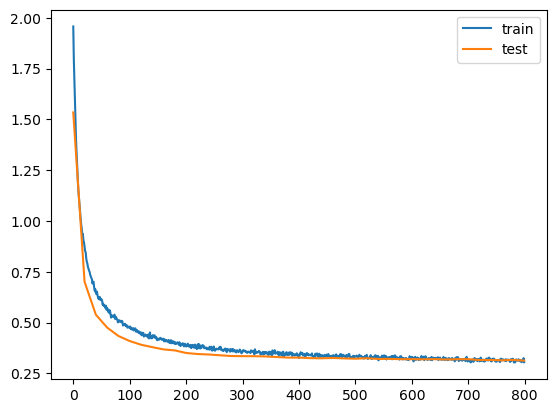

In [5]:
params = {
    'model_type': NAVAR, 
    'lambda1': 0.1,
    'hidden_dim': 16, 
    'weight_sharing': True, 
    'epochs': 500,
    'dropout': 0.2,
    'experiment_name': 'causeme',
    'lr': 1e-3,
    'weight_decay': 1e-8,
    'test_size': 0.3,
    'kernel_size': 2,
    'n_blocks': 2,
    'n_layers': 2,
    'use_positional_embedding': False
}
if test:
    all_test_results = []
    for i in range(1):
        all_test_results.append(train_model(
            experiment_run=name,
            dataset={'name': dataset['name'], 'data':dataset['data'][i:i+1]},
            **params))
    print(all_test_results[0].keys())
    
    plt.plot(*all_test_results[0]['train_metrics']['loss'], label='train')
    plt.plot(*all_test_results[0]['test_metrics']['loss'], label='test')
    plt.legend()
    plt.show()

Dataset 1/1


[train] loss=0.29 [test] loss=0.29: 100%|████████████████████████████████████████████| 800/800 [02:05<00:00,  6.38it/s]


dict_keys(['train_artifacts', 'test_artifacts', 'model_params', 'train_data', 'test_data', 'train_metrics', 'test_metrics'])


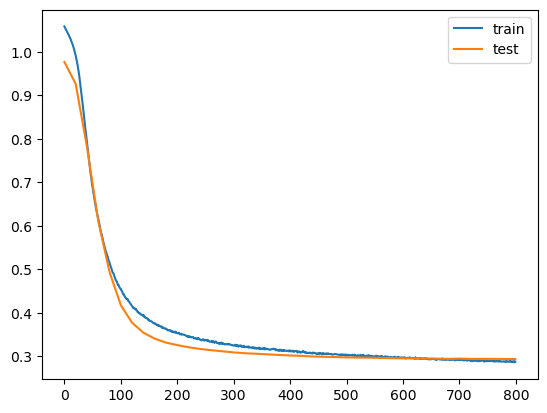

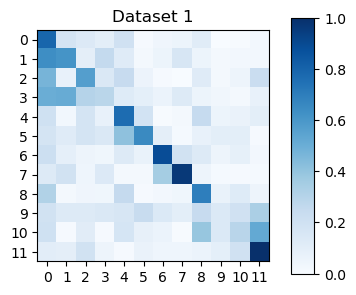

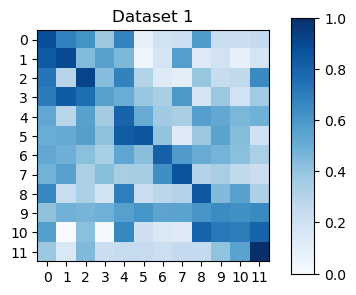

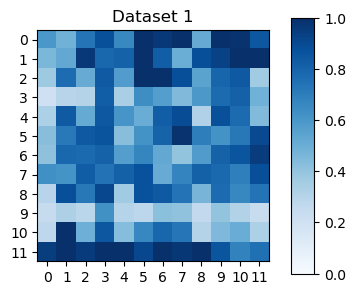

In [6]:
params = {
    'model_type': TAMCaD_UA, 
    'n_ensembles': 30,
    'gamma': 0.0,
    'lambda1': 0.1,
    'hidden_dim': 16, 
    'weight_sharing': True, 
    'epochs': 500,
    'dropout': 0.2,
    'experiment_name': 'causeme',
    'lr': 1e-3,
    'weight_decay': 1e-8,
    'test_size': 0.3,
    'kernel_size': 2,
    'n_blocks': 2,
    'n_layers': 2,
    'use_positional_embedding': False
}

all_datasets = 1 if test else dataset['data'].size(0)

all_results = []
for i in range(all_datasets):
    print(f'Dataset {i+1}/{all_datasets}')
    all_results.append(train_model(
        experiment_run=name,
        dataset={'name': dataset['name'], 'data':dataset['data'][i:i+1]},
        **params))
print(all_results[0].keys())

plt.plot(*all_results[0]['train_metrics']['loss'], label='train')
plt.plot(*all_results[0]['test_metrics']['loss'], label='test')
plt.legend()
plt.show()

if test:
    plot_causal_matrix(all_test_results)
plot_causal_matrix(all_results, plot_ep=True)

In [10]:
if not test:
    scores = torch.stack([r['test_artifacts']['matrix'] for r in all_results]).transpose(-1, -2)
    print(scores.shape)
    write_causeme_predictions('TAMCaD_UA', name, scores, type='UA', hidden_dim=params['hidden_dim'])

torch.Size([1, 12, 12])
